In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow.keras.utils import to_categorical

In [2]:
# dataset 을 로드합니다.
mnist = keras.datasets.mnist

# X_train, y_train, X_test, y_test 의 형식
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = np.expand_dims(train_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)

train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
# 간단한 모델을 하나 만들어봅니다.

def make_my_simple_model(input_shape=(28, 28, 1)):
    model = Sequential([
    Conv2D(32, (2, 2), input_shape=input_shape),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Flatten(),
    Dense(10),
    Activation('softmax')
    ])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())    

    return model

X_train first batch size: (10, 28, 28, 1)
y_train first batch size: (10, 10)


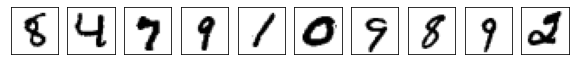

In [4]:
# tf dataset을 이용하는 방법
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(buffer_size=100000).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)

for batch_data, batch_label in train_dataset.take(1):
    print(f"X_train first batch size: {batch_data.shape}")
    print(f"y_train first batch size: {batch_label.shape}")

    plt.figure(figsize=(10,5))
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(np.squeeze(batch_data[i], axis=2), cmap=plt.cm.binary)
    plt.show()

In [10]:
model = make_my_simple_model((28, 28, 1))
history = model.fit(train_dataset, 
                    validation_data=test_dataset,
                    epochs=3, 
                    verbose=1)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 27, 27, 32)        160       
_________________________________________________________________
activation_8 (Activation)    (None, 27, 27, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                54090     
_________________________________________________________________
activation_9 (Activation)    (None, 10)                0         
Total params: 54,250
Trainable params: 54,250
Non-trainable params: 0
__________________________________________________

X_train first batch size: (32, 32, 32, 1)
y_train first batch size: (32, 10)


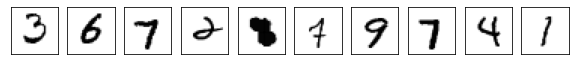

In [13]:
# custom dataset 만들기

def custom_pader(images):
    output_list = []

    padding_size = ((2, 2), (2, 2), (0, 0))
    for i, image in enumerate(images):
        image = np.pad(image, padding_size, 'constant', constant_values=0)
        image = tf.cast(image, tf.float32)
        output_list.append(image)
    
    return tf.stack(output_list)

def tf_custom_pader_wrapper(images, labels):
    [output_images, ] = tf.py_function(custom_pader, [images], [tf.float32])
    output_images.set_shape(tf.TensorShape([None, None, None, None]))

    return output_images, labels

batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(buffer_size=100000).batch(batch_size).map(tf_custom_pader_wrapper)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size).map(tf_custom_pader_wrapper)

for batch_data, batch_label in train_dataset.take(1):
    print(f"X_train first batch size: {batch_data.shape}")
    print(f"y_train first batch size: {batch_label.shape}")

    plt.figure(figsize=(10,5))
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(np.squeeze(batch_data[i], axis=2), cmap=plt.cm.binary)
    plt.show()

In [14]:
model_2 = make_my_simple_model((32, 32, 1))
history_2 = model_2.fit(train_dataset, 
                        validation_data=test_dataset,
                        epochs=3, 
                        verbose=1)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 31, 31, 32)        160       
_________________________________________________________________
activation_12 (Activation)   (None, 31, 31, 32)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 7200)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                72010     
_________________________________________________________________
activation_13 (Activation)   (None, 10)                0         
Total params: 72,170
Trainable params: 72,170
Non-trainable params: 0
__________________________________________________

X_train first batch size: (32, 28, 28, 1)
y_train first batch size: (32, 10)


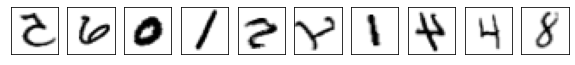

In [15]:
# image data generator 를 이용한 방법

from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

train_dataset = train_datagen.flow(
    x=train_images, y=train_labels, batch_size=batch_size, shuffle=True
)

test_datagen = ImageDataGenerator(
        rescale=1./255
        )

test_dataset = test_datagen.flow(
    x=test_images, y=test_labels, batch_size=batch_size, shuffle=False
)

batch_data, batch_label = train_dataset.next()

print(f"X_train first batch size: {batch_data.shape}")
print(f"y_train first batch size: {batch_label.shape}")

plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.squeeze(batch_data[i], axis=2), cmap=plt.cm.binary)
plt.show()

In [21]:
model_3 = make_my_simple_model((28, 28, 1))
history_3 = model_3.fit_generator(train_dataset,
                        validation_data=test_dataset,
                        steps_per_epoch=len(train_images) // batch_size,
                        validation_steps=len(test_images) // batch_size,
                        epochs=3, 
                        verbose=1)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 27, 27, 32)        160       
_________________________________________________________________
activation_22 (Activation)   (None, 27, 27, 32)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 5408)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                54090     
_________________________________________________________________
activation_23 (Activation)   (None, 10)                0         
Total params: 54,250
Trainable params: 54,250
Non-trainable params: 0
_________________________________________________

In [22]:
# 물론 직접 넣어도 됩니다.

model_4 = make_my_simple_model((28, 28, 1))
history_4 = model_4.fit(x=train_images, 
                        y=train_labels,
                        epochs=3,
                        validation_data=(test_images, test_labels),
                        verbose=1)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 27, 27, 32)        160       
_________________________________________________________________
activation_24 (Activation)   (None, 27, 27, 32)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 5408)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)                54090     
_________________________________________________________________
activation_25 (Activation)   (None, 10)                0         
Total params: 54,250
Trainable params: 54,250
Non-trainable params: 0
_________________________________________________